# Baseline Models

In this notebook, we reproduce the results of the baseline models according to https://github.com/CVxTz/ECG_Heartbeat_Classification as a starting point and benchmark for our further work.

In [55]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# keras
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras import activations
import h5py

# sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# custom modules
from utils import display_result, hb_plot, plot_multiple_heartbeats

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Model Architecture

In [57]:
def get_baseline_cnn_model(dataset, trainable = True):

    nclass = 5 if dataset == 'mit' else 1
    final_activation_fn = activations.softmax if dataset == 'mit' \
        else activations.sigmoid
    loss_fn = losses.sparse_categorical_crossentropy if dataset == 'mit' \
        else losses.binary_crossentropy

    inp = Input(shape=(187, 1), name="input_1")
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", trainable=trainable, name="conv_1")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", trainable=trainable, name="conv_2")(img_1)
    img_1 = MaxPool1D(pool_size=2, name="maxpool_1")(img_1)
    img_1 = Dropout(rate=0.1, name="dropout_1")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_3")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_4")(img_1)
    img_1 = MaxPool1D(pool_size=2, name="maxpool_2")(img_1)
    img_1 = Dropout(rate=0.1, name="dropout_3")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_5")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_6")(img_1)
    img_1 = MaxPool1D(pool_size=2, name="maxpool_3")(img_1)
    img_1 = Dropout(rate=0.1, name="dropout_4")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_7")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", trainable=trainable, name="conv_8")(img_1)
    img_1 = GlobalMaxPool1D(name="globmaxpool_1")(img_1)
    img_1 = Dropout(rate=0.2, name="dropout_5")(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=final_activation_fn, name=f"dense_3_{dataset}")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=loss_fn, metrics=['acc'])
    
    model.summary()
    
    return model

### Set global training parameters

In [58]:
EPOCHS = 1000
BATCH_SIZE = 32

### Initialize result file

In [59]:
results = pd.DataFrame({ 'model' : [], 'f1': [], 'acc': [] })

## MITBIH Model

### Load data

In [60]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Visualize data

In [61]:
# heartbeat classes
hb_classes = { 0 : 'normal (N)',          # normal beat
               1 : 'SVEB (S)',            # supraventricular ectopic beat (SVEB)
               2 : 'VEB (V)',             # ventricular ectopic beat (VEB)
               3 : 'Fusion beat (F)',     # fusion beat (F)
               4 : 'unknown beat typ (Q)' # unknown beat type (Q)
             }

In [62]:
cls_weights = class_weight.compute_class_weight('balanced', classes = np.unique(Y),  y = Y)
cls_weight_dict = dict(enumerate(cls_weights))

#### plot class distribution

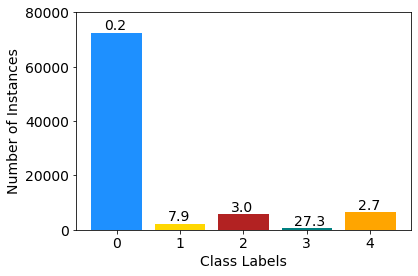

In [63]:
# plot class distribution
colors = ["dodgerblue", "gold", "firebrick", "teal", "orange"]
x = np.arange(0,5)
h, bins = np.histogram(Y, 5)
plt.bar(x, h, color=colors)
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.xticks(x)
plt.ylim(0, 80000)

for index, value in enumerate(h):
    plt.text(x[index]-0.2, value+1000, str(np.round(cls_weight_dict[index],1)))

plt.show()

#### Plot mean heartbeats (and +/- standard deviation) per class

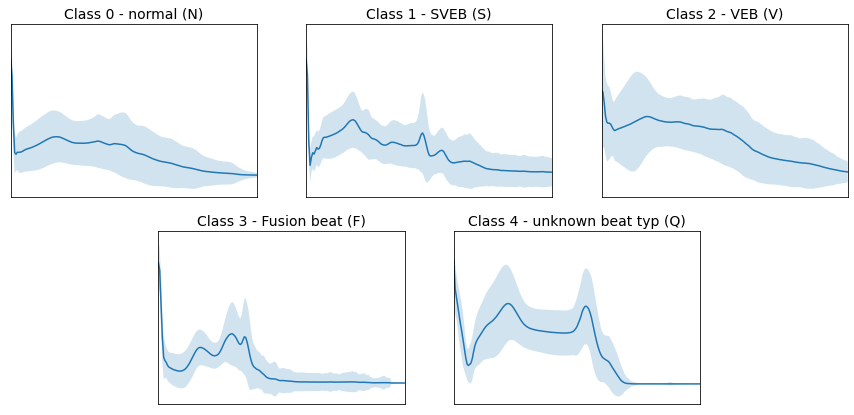

In [64]:
fig = plt.figure(figsize=(15, 7)) 
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.5)

for cid in range(5):
    if cid < 3:
        ax = plt.subplot(gs[0, 2*cid:2*(cid+1)], )
    else:
        ax = plt.subplot(gs[1, (2*(cid-3)+1):(2*(cid-2)+1)], )
    hb_plot(ax, X[Y==cid].squeeze())
    ax.set_title("Class {} - {}".format(cid, hb_classes[cid]), fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

# uncomment to save plot
# fig.savefig('./output/plot_hb_classes.png')

#### plot multiple heartbeats per class

In [65]:
NO_HEARTBEATS_PER_CLASS = 4

In [66]:
ix = [ np.random.choice(np.argwhere(Y==hb_class).flatten(),NO_HEARTBEATS_PER_CLASS,replace=False) for hb_class in range(5)]
ix = np.concatenate(ix)
heartbeats = X[ix,:]
labels = Y[ix]

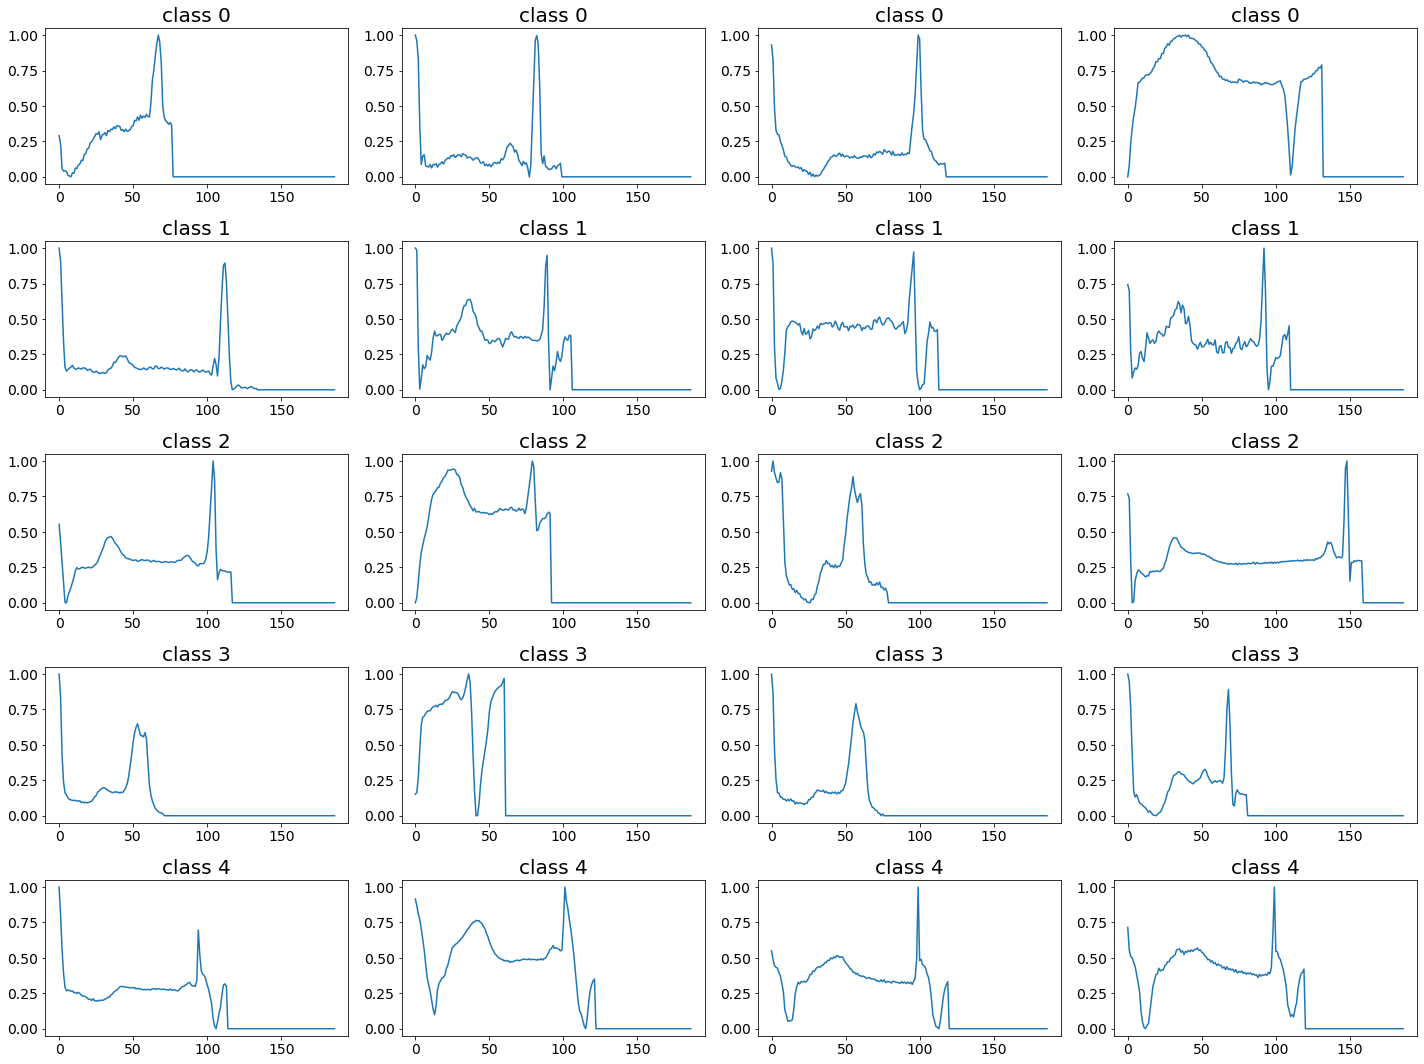

In [67]:
plot_multiple_heartbeats(heartbeats,labels,n_cols=NO_HEARTBEATS_PER_CLASS)

### Set-up model

In [ ]:
model = get_baseline_cnn_model('mit', trainable = True)

file_path = "./models/baseline_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  

### Training

In [ ]:
model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list, validation_split=0.1)

### Make predictions and determine scores

f1 score micro:           0.98392
f1 score macro:           0.9099
accuracy score:           0.98392
balanced accuracy score:  0.88355


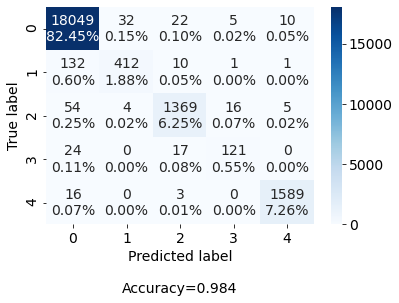

In [70]:
model.load_weights(file_path)

pred_test_proba = model.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")
acc = accuracy_score(Y_test, pred_test)

display_result(Y_test, pred_test)

In [71]:
# Add scores to result file
results = pd.concat([results, pd.DataFrame([['MITBIH', f1, acc]], columns=results.columns)], axis=0).reset_index(drop=True)

## PTBDB baseline

### Load data

In [72]:
df_1 = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

In [73]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

In [74]:
Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Set-up model

In [ ]:
model = get_baseline_cnn_model('ptbdb', trainable = True)

file_path = "./models/baseline_cnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  

### Full training of model

In [ ]:
model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list, validation_split=0.1)

### Make predictions and determine scores

f1 score micro:           0.99416
f1 score macro:           0.99272
accuracy score:           0.99416
balanced accuracy score:  0.99253
AuPR score:               0.99915
AuROC score:              0.99829


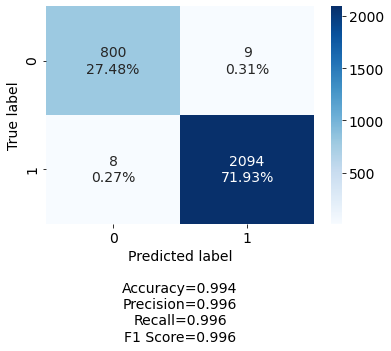

In [77]:
model.load_weights(file_path)

pred_test_proba = model.predict(X_test)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba] 

f1 = f1_score(Y_test, pred_test, average="macro")
acc = accuracy_score(Y_test, pred_test)

display_result(Y_test, pred_test, curve=True, proba=pred_test_proba)

In [78]:
# Add scores to result file
results = pd.concat([results, pd.DataFrame([['PTBDB', f1, acc]], columns=results.columns)], axis=0).reset_index(drop=True)

## PTBDB transfer full update

### Set-up model

In [ ]:
model = get_baseline_cnn_model('ptbdb', trainable = True)

file_path = "./models/baseline_cnn_ptbdb_transfer_fullupdate.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat] 

### Load pretrained weights

In [80]:
model.load_weights("./models/baseline_cnn_mitbih.h5", by_name=True)

### Train model

In [ ]:
model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list, validation_split=0.1)

### Make predictions and determine scores

f1 score micro:           0.99519
f1 score macro:           0.99401
accuracy score:           0.99519
balanced accuracy score:  0.99401
AuPR score:               0.99894
AuROC score:              0.99796


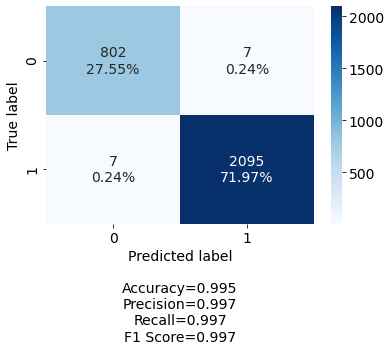

In [82]:
model.load_weights(file_path)

pred_test_proba = model.predict(X_test)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba] 

f1 = f1_score(Y_test, pred_test, average='macro')
acc = accuracy_score(Y_test, pred_test)

display_result(Y_test, pred_test, curve=True, proba=pred_test_proba)

In [83]:
# Add scores to result file
results = pd.concat([results, pd.DataFrame([['PTBDB transfer full', f1, acc]], columns=results.columns)], axis=0).reset_index(drop=True)

## PTBDB transfer learning with freezed layers

### Set-up model

In [ ]:
model = get_baseline_cnn_model('ptbdb', trainable = False)

file_path = "./models/baseline_cnn_ptbdb_transfer_freezed.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat] 

### Load pretrained weights

In [85]:
model.load_weights("./models/baseline_cnn_mitbih.h5", by_name=True)

### Train model

In [ ]:
model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list, validation_split=0.1)

### Make predictions and determine scores

f1 score micro:           0.95328
f1 score macro:           0.94257
accuracy score:           0.95328
balanced accuracy score:  0.94864
AuPR score:               0.99479
AuROC score:              0.98818


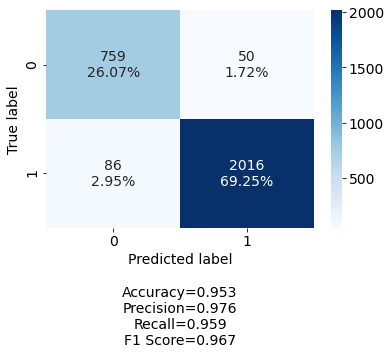

In [87]:
model.load_weights(file_path)

pred_test_proba = model.predict(X_test)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba] 

f1 = f1_score(Y_test, pred_test, average='macro')
acc = accuracy_score(Y_test, pred_test)

display_result(Y_test, pred_test, curve=True, proba=pred_test_proba)

In [88]:
# Add scores to result file
results = pd.concat([results, pd.DataFrame([['PTBDB transfer freezed', f1, acc]], columns=results.columns)], axis=0).reset_index(drop=True)

## Baseline Results

In [90]:
results

,model,f1,acc
0,MITBIH,0.909900,0.983921
1,PTBDB,0.992722,0.994160
2,PTBDB transfer full,0.994009,0.995191
3,PTBDB transfer freezed,0.942573,0.953281


Note that due to the stochasticity of the results (if seeds are not explicity and consistently set) our results slightly differ from what they report on GitHub:

|                     | f1    | acc   |
|---------------------|-------|-------|
| MITBIH              | 0.915 | 0.985 |
| PTBDB               | 0.988 | 0.983 |
| PTBDB transfer full | 0.994 | 0.992 |
| PTBDB transfer freeze | 0.969 | 0.956 |

In [29]:
# Uncomment to store results

# results.to_csv('./output/baseline_results.csv', index=False)